## GARCH Modeling

**ARCH and GARCH models**<br>
-Volatility clustering.<br>
-GARCH basics.<br>
-Simulate ARCH and GARCH series.<br>
-Impact of model parameters.<br>
-GARCH model implementation and forecasting.<br>

**Model configuration**<br>
-Distribution of standardised residuals.<br>
-Normal and skewed-t distribution.<br>
-Model mean assumptions (constant, AR).<br>
-Assymetric shocks (EGARCH, GJR-GARCH).<br>

**Model performance evaluation**<br>
-Keep it simple stupid (KISS).<br>
-P-values and t-stats.<br>
-Autocorrelation detction (ACF plots, Ljung-Box test).<br>
-Log-likelihood, AIC/BIC.<br>
-Backtesting and Mean Absolute - Mean Squared Error (MAE - MSE).<br>

**VaR with GARCH**<br>
-VaR, or covariance in the context of MPT, can incorporatethe  time-varying characteristics of volatility with GARCH giving a more realistic representation of risk.<br>
-Use GARCH to calculate:<br>
--Parametric VaR.<br>
--Empirical VaR.<br>
--Dynamic portfolio covariance.<br>
--Dynamic portfolio beta.<br>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import path

 -----------------------------------------------------------------------------------------------------------------------------------------------------------------<br>
### ARCH and GARCH models

-Volatility is the dispersion of the price of an asset. It describes uncertainties surrounding the movement of the price. Standard deviation or variance are used to estimate volatility.<br>

-SD = Squared Root of (Σ ( x_i - x_mean) ^ 2 / (n-1) ) = Squared Root of Variance<br>

-Generalised AutoRegressive Conditional Heteroskedasticity Models: Hetero means different and skedasis means dispersion which is to say that a series exhibits varying volatilty systematically over time (vol tends to decrease or increase systematically over time).<br>

-One way to detect heteroskedasticity is to plot the data. The right set displays time-dependent fluctuations.<br>
![title](assets/garch/garch_heteroskedasticity.png)

-Volatility clustering describes the situation when large price changes are more likely to be followed more large changes and vice versa (lower prices changes followed by more lower prices changes).<br>

-This happens because the market needs time to adapt to a shock (so not everyon acts at exactly the same time on the same info? but maybe a few days or weeks or months need to pass before the full event is reflected in the price).<br>

-Volatility clustering is frequently observed in financial market data, and it poses a challenge for time series modeling.<br>

-White noise: uncorrelated random variables with a zero mean and finite variance. If a prediction model is working properly then its residuals (predicted minus actual values) will be a white noise series. This means the model has taken care of all the predictable components of a time series it seeks to predict leaving only the unpredictable white noise part.<br>

-A GARCH model predicts volatility at time t as a weighted average of past information. Constraints: (1) ω, α, β>0, (2) a+b<1, (3) long-run variance equals ω/(1-α-β). Intuition: the larger the a the biggest the immediate impact of the shock (residuals), the larger the β the biggest the duration of past information (higher vol periods tend to persist).<br>

![title](assets/garch/garch_notation.png)
![title](assets/garch/garch_model.png)

-GARCH variance forecast can be interpreted as a weighted average of three different variance forecasts. One is a constant variance that corresponds to the long run average. The second is the new information that was not available when the previous forecast was made. The third is the forecast that was made in the previous period. The weights on these three forecasts determine how fast the variance changes with new information and how fast it reverts to its long run mean.

In [3]:
sp_price = pd.read_csv('./assets/garch/garch_SP500.csv',index_col='Date')
sp_price.head()

,Close,Return
Date,,
2010/07/01,1027.37,-0.324048
2010/07/02,1022.58,-0.466239
2010/07/06,1028.06,0.535899
2010/07/07,1060.27,3.133086
2010/07/08,1070.24,0.940327


              Close    Return
Date                         
2019/09/27  2961.79 -0.531633
2019/09/30  2976.74  0.504762
2019/10/01  2940.25 -1.225838
2019/10/02  2887.61 -1.790324
2019/10/03  2910.63  0.797199
2019/10/04  2952.01  1.421685
2019/10/07  2938.79 -0.447830
2019/10/08  2893.06 -1.556083
2019/10/09  2919.40  0.910455
2019/10/10  2938.13  0.641570


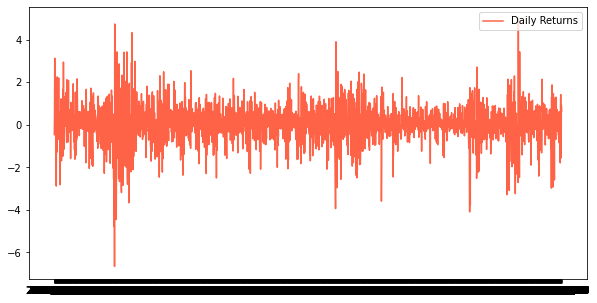

In [4]:
# Calculate daily returns as percentage price changes
sp_price['Return'] = 100 * (sp_price['Close'].pct_change())

# View the data
print(sp_price.tail(10))

# plot the data
plt.figure(figsize=(10,5))
plt.plot(sp_price['Return'], color = 'tomato', label = 'Daily Returns')
plt.legend(loc='upper right')
plt.show()

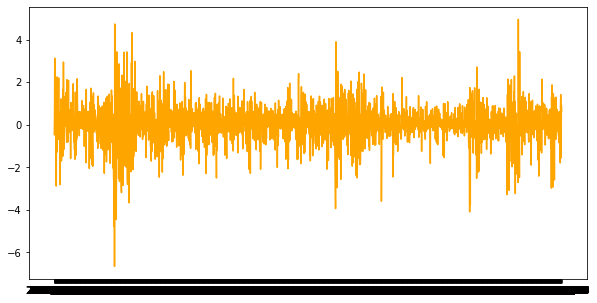

Daily volatility:  0.92%


In [5]:
# Plot the price returns
sp_data = sp_price.copy()
plt.figure(figsize=(10,5))
plt.plot(sp_data['Return'], color = 'orange')
plt.show()

# Calculate daily std of returns
std_daily = sp_data['Return'].std()
print('Daily volatility: ', '{:.2f}%'.format(std_daily))

In [6]:
def simulate_GARCH(n, omega, alpha, beta = 0):
    
    np.random.seed(4)
    
    # Initialize the parameters
    white_noise = np.random.normal(size = n)
    resid = np.zeros_like(white_noise)
    variance = np.zeros_like(white_noise)
    
    for t in range(1, n):
        # Simulate the variance (sigma squared)
        variance[t] = omega + alpha * resid[t-1]**2 + beta * variance[t-1]
        # Simulate the residuals
        resid[t] = np.sqrt(variance[t]) * white_noise[t]    
    
    return resid, variance

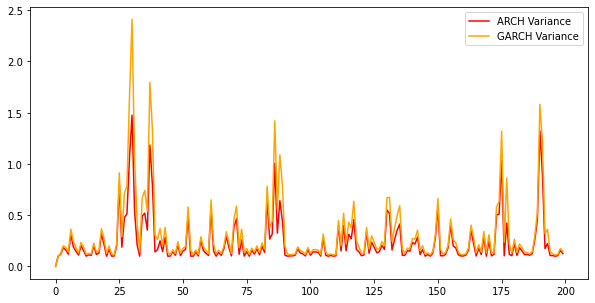

In [7]:
# Simulate a ARCH(1) series
arch_resid, arch_variance = simulate_GARCH(n= 200, 
                                           omega = 0.1, alpha = 0.7)
# Simulate a GARCH(1,1) series
garch_resid, garch_variance = simulate_GARCH(n= 200, 
                                             omega = 0.1, alpha = 0.7,
                                             beta = 0.1)
# Plot the ARCH variance
plt.figure(figsize=(10,5))
plt.plot(arch_variance, color = 'red', label = 'ARCH Variance')
# Plot the GARCH variance
plt.plot(garch_variance, color = 'orange', label = 'GARCH Variance')
plt.legend()
plt.show()

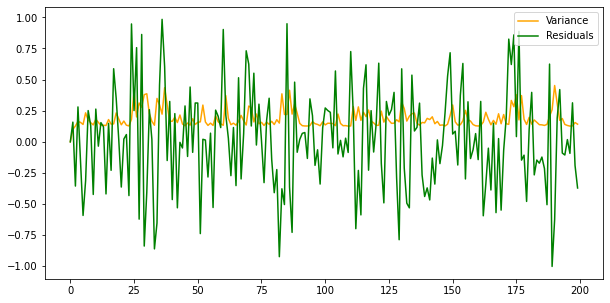

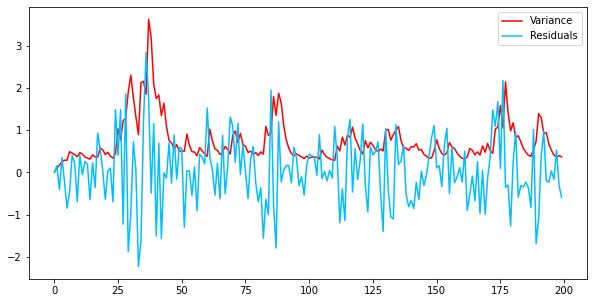

In [8]:
# First simulated GARCH
sim_resid, sim_variance = simulate_GARCH(n = 200,  omega = 0.1, alpha = 0.3, beta = 0.2)
plt.figure(figsize=(10,5))
plt.plot(sim_variance, color = 'orange', label = 'Variance')
plt.plot(sim_resid, color = 'green', label = 'Residuals')
plt.legend(loc='upper right')
plt.show()

# Second simulated GARCH
sim_resid, sim_variance = simulate_GARCH(n = 200,  omega = 0.1,  alpha = 0.3, beta = 0.6)
plt.figure(figsize=(10,5))
plt.plot(sim_variance, color = 'red', label = 'Variance')
plt.plot(sim_resid, color = 'deepskyblue', label = 'Residuals')
plt.legend(loc='upper right')
plt.show()

-GARCH models are estimated using the Maximum Likelihood Method. It means that the fitting process tries to find the parameters values for which the GARCH models is **most likely** to have generated the observed values of the time serie process.

In [9]:
from arch import arch_model

print(help(arch_model))

Help on function arch_model in module arch.univariate.mean:

arch_model(y: 'Optional[ArrayLike]', x: 'Optional[ArrayLike]' = None, mean: "Literal[('Constant', 'Zero', 'LS', 'AR', 'ARX', 'HAR', 'HARX', 'constant', 'zero')]" = 'Constant', lags: 'Union[None, int, List[int], Int32Array, Int64Array]' = 0, vol: "Literal[('GARCH', 'ARCH', 'EGARCH', 'FIARCH', 'HARCH')]" = 'GARCH', p: 'Union[int, List[int]]' = 1, o: 'int' = 0, q: 'int' = 1, power: 'float' = 2.0, dist: "Literal[('normal', 'gaussian', 't', 'studentst', 'skewstudent', 'skewt', 'ged', 'generalized error')]" = 'normal', hold_back: 'Optional[int]' = None, rescale: 'Optional[bool]' = None) -> 'HARX'
    Initialization of common ARCH model specifications
    
    Parameters
    ----------
    y : {ndarray, Series, None}
        The dependent variable
    x : {np.array, DataFrame}, optional
        Exogenous regressors.  Ignored if model does not permit exogenous
        regressors.
    mean : str, optional
        Name of the mean mode

Iteration:      4,   Func. Count:     29,   Neg. LLF: 3798.1233469401104
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2783.785085499902
Iteration:     12,   Func. Count:     75,   Neg. LLF: 2770.082165044935
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2770.082165044935
            Iterations: 13
            Function evaluations: 79
            Gradient evaluations: 13

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2770.08
Distribution:                  Normal   AIC:                           5548.16
Method:            Maximum Likelihood   BIC:                           5571.19
                                        No. Observations:                 2335
Date:               

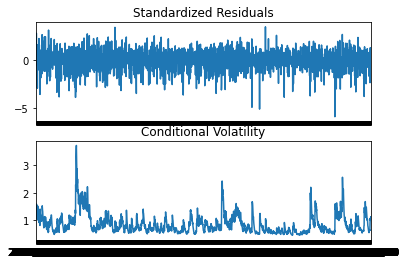

In [10]:
# Specify GARCH model assumptions -> GARCH(1,1)
basic_gm = arch_model(sp_data['Return'].dropna(), p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model
gm_result = basic_gm.fit(update_freq = 4)

# Display model fitting summary
print('')
print(gm_result.summary())

# Plot fitted results
gm_result.plot()
plt.show()

In [11]:
# Make 5-period ahead forecast
gm_forecast = gm_result.forecast(horizon = 5)

# Print the forecast variance
print(gm_forecast.variance[-1:])

                 h.1      h.2       h.3       h.4       h.5
Date                                                       
2019/10/10  0.994069  0.98828  0.982757  0.977488  0.972461


/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 -----------------------------------------------------------------------------------------------------------------------------------------------------------------<br>
### GARCH model configuration

-Residuals are the differences between predicted returns and the mean returns. And standardized residuals are the residuals divided by the model estimated volatility. Standardised residuals = residuals (e_t) / volatility (σ_t).<br>

-GARCH models enable one to specify the distribution assumptions of the standardized residuals. By default, a normal distribution is assumed, which has a symmetric, bell-shaped probability density curve. Other options include Student's t-distribution and skewed Student's t-distribution.<br>

-Mean configuration: In practice, returns and volatility are modeled in separate processes. Typically the mean assumptions influence predicted returns, but have a minor effect on the volatility estimations.<br>

-GARCH models assume positive and negative news has a symmetric impact on volatility. However, in reality the market tends to take the stairs up and the elevator down. In other words, the impact is usually asymmetric, and negative news tends to affect the volatility more than positive news. GJR and EGARCH models help model assymetric shocks by incorporating an additional component in the GARCH model that is triggered once a condition is met (e.g. negative returns).

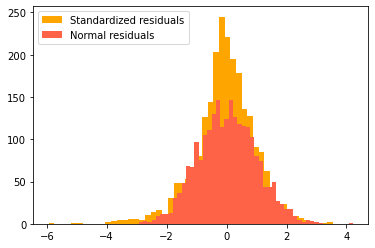

In [12]:
# Obtain model estimated residuals and volatility
gm_resid = gm_result.resid
gm_std = gm_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Plot the histogram of the standardized residuals
plt.hist(gm_std_resid, bins = 50, 
         facecolor = 'orange', label = 'Standardized residuals')

normal_resid = [np.random.normal() for i in range(len(gm_resid))]
plt.hist(normal_resid, bins = 50, 
         facecolor = 'tomato', label = 'Normal residuals')
plt.legend(loc = 'upper left')
plt.show()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 109840.37880541019
Iteration:      2,   Func. Count:     19,   Neg. LLF: 134482.95887494896
Iteration:      3,   Func. Count:     28,   Neg. LLF: 18474.707357875606
Iteration:      4,   Func. Count:     36,   Neg. LLF: 5471.602579325621
Iteration:      5,   Func. Count:     44,   Neg. LLF: 4963.102957824691
Iteration:      6,   Func. Count:     52,   Neg. LLF: 2734.2288269058663
Iteration:      7,   Func. Count:     60,   Neg. LLF: 2727.7741406594555
Iteration:      8,   Func. Count:     68,   Neg. LLF: 5015.2291784435065
Iteration:      9,   Func. Count:     76,   Neg. LLF: 2742.0455830623046
Iteration:     10,   Func. Count:     84,   Neg. LLF: 2697.5698952216053
Iteration:     11,   Func. Count:     92,   Neg. LLF: 2690.1090740137242
Iteration:     12,   Func. Count:    100,   Neg. LLF: 2688.684634827148
Iteration:     13,   Func. Count:    107,   Neg. LLF: 2688.6644250985983
Iteration:     14,   Func. Count:    114,   Neg. LLF: 

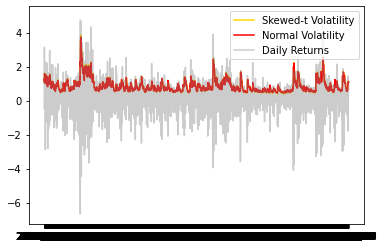

In [13]:
# Specify GARCH model assumptions
skewt_gm = arch_model(sp_data['Return'].dropna(), p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'skewt')
# Fit the model
skewt_result = skewt_gm.fit()

# Get model estimated volatility
skewt_vol = skewt_result.conditional_volatility

# Plot model fitting results
plt.plot(skewt_vol, color = 'gold', label = 'Skewed-t Volatility')

normal_vol = gm_result.conditional_volatility
plt.plot(normal_vol, color = 'red', label = 'Normal Volatility')

plt.plot(sp_data['Return'].dropna(), color = 'grey',  label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.show()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 20021.465944394076
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1488857.7611993484
Iteration:      3,   Func. Count:     23,   Neg. LLF: 2886.600673953214
Iteration:      4,   Func. Count:     29,   Neg. LLF: 3798.1233469401104
Iteration:      5,   Func. Count:     35,   Neg. LLF: 2909.747738349709
Iteration:      6,   Func. Count:     41,   Neg. LLF: 2779.3643028101137
Iteration:      7,   Func. Count:     47,   Neg. LLF: 5552.887021563801
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2783.785085499902
Iteration:      9,   Func. Count:     59,   Neg. LLF: 2771.021774034304
Iteration:     10,   Func. Count:     65,   Neg. LLF: 2770.08239257275
Iteration:     11,   Func. Count:     70,   Neg. LLF: 2770.082166047562
Iteration:     12,   Func. Count:     75,   Neg. LLF: 2770.082165044935
Iteration:     13,   Func. Count:     79,   Neg. LLF: 2770.0821650452135
Optimization terminated successfully    (Exit mode 0)
      

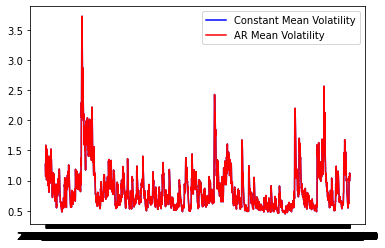

NameError: name 'rmean_result' is not defined

In [14]:
cmean_result = arch_model(sp_data['Return'].dropna(), p = 1, q = 1,
                          mean = 'constant', vol = 'GARCH', dist = 'normal').fit()

armean_result = arch_model(sp_data['Return'].dropna(), p = 1, q = 1,
                          mean = 'AR', vol = 'GARCH', dist = 'normal').fit()

# Print model summary of GARCH with constant mean
print(cmean_result.summary())
# Print model summary of GARCH with AR mean
print(armean_result.summary())

# Plot model volatility 
plt.plot(cmean_result.conditional_volatility, color = 'blue', label = 'Constant Mean Volatility')
plt.plot(armean_result.conditional_volatility, color = 'red', label = 'AR Mean Volatility')
plt.legend(loc = 'upper right')
plt.show()

# Check correlation of volatility estimations
print(np.corrcoef(cmean_result.conditional_volatility, 
                  rmean_result.conditional_volatility)[0,1])

In [128]:
btc = pd.read_csv('./assets/garch/garch_bitcoin.csv',index_col='Date')
btc.head()

,Close,Return
Date,,
2014/03/27,513.58,-8.553826
2014/03/28,504.00,-1.865337
2014/03/31,465.75,-7.589286
2014/04/01,482.23,3.538379
2014/04/02,429.86,-10.859963


                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                       Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -3966.26
Distribution:      Standardized Student's t   AIC:                           7944.52
Method:                  Maximum Likelihood   BIC:                           7976.33
                                              No. Observations:                 1483
Date:                      Sun, Oct 17 2021   Df Residuals:                     1482
Time:                              18:37:17   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

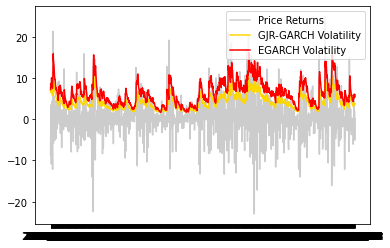

In [129]:
# ------------------------------------------------------------------------------------------------
# Specify model assumptions
gjr_gm = arch_model(btc['Return'], p = 1, q = 1, o = 1, vol = 'GARCH', dist = 't')

# Fit the model
gjrgm_result = gjr_gm.fit(disp = 'off')

# Print model fitting summary
print(gjrgm_result.summary())

# ------------------------------------------------------------------------------------------------
# Specify model assumptions
egarch_gm = arch_model(btc['Return'], p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't')

# Fit the model
egarch_result = egarch_gm.fit(disp = 'off')

# Print model fitting summary
print(egarch_result.summary())

# ------------------------------------------------------------------------------------------------
# Plot the actual Bitcoin returns
plt.plot(btc['Return'], color = 'grey', alpha = 0.4, label = 'Price Returns')

# Plot GJR-GARCH estimated volatility
gjrgm_vol = gjrgm_result.conditional_volatility
plt.plot(gjrgm_vol, color = 'gold', label = 'GJR-GARCH Volatility')

# Plot EGARCH  estimated volatility
egarch_vol = egarch_result.conditional_volatility
plt.plot(egarch_vol, color = 'red', label = 'EGARCH Volatility')
plt.legend(loc = 'upper right')
plt.show()

**Rolling window forecast**

-Rolling window forecast is very popular in financial modeling, because it is adaptive to new market observations as time moves forward. It is commonly implemented with either an "expanding window" or a "fixed window" approach.

-A trade-off between variance and bias.

Iteration:      5,   Func. Count:     32,   Neg. LLF: 199.05036714225162
Iteration:     10,   Func. Count:     60,   Neg. LLF: 197.81735039523664
Optimization terminated successfully    (Exit mode 0)
            Current function value: 197.81735039523664
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11
Iteration:      5,   Func. Count:     31,   Neg. LLF: 196.79614184233657
Iteration:     10,   Func. Count:     58,   Neg. LLF: 196.0063560880958
Optimization terminated successfully    (Exit mode 0)
            Current function value: 196.00635608826553
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Iteration:      5,   Func. Count:     32,   Neg. LLF: 197.83798734273518
Optimization terminated successfully    (Exit mode 0)
            Current function value: 196.42809371420475
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 9
Iteratio

/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      5,   Func. Count:     38,   Neg. LLF: 199.2059045167574
Optimization terminated successfully    (Exit mode 0)
            Current function value: 192.5866421293225
            Iterations: 8
            Function evaluations: 54
            Gradient evaluations: 8
Iteration:      5,   Func. Count:     38,   Neg. LLF: 199.54188867420987
Optimization terminated successfully    (Exit mode 0)
            Current function value: 191.73165250526645
            Iterations: 7
            Function evaluations: 50
            Gradient evaluations: 7
Iteration:      5,   Func. Count:     38,   Neg. LLF: 200.27745858973384
Optimization terminated successfully    (Exit mode 0)
            Current function value: 190.729486104994
            Iterations: 7
            Function evaluations: 50
            Gradient evaluations: 7
Iteration:      5,   Func. Count:     38,   Neg. LLF: 199.71402479686168
Optimization terminated successfully    (Exit mode 0)
            Current function value

/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      5,   Func. Count:     37,   Neg. LLF: 241.88546045214747
Optimization terminated successfully    (Exit mode 0)
            Current function value: 188.84529837549474
            Iterations: 9
            Function evaluations: 58
            Gradient evaluations: 9
Iteration:      5,   Func. Count:     38,   Neg. LLF: 190.6875692828601
Optimization terminated successfully    (Exit mode 0)
            Current function value: 188.69803951522073
            Iterations: 9
            Function evaluations: 58
            Gradient evaluations: 9
Iteration:      5,   Func. Count:     38,   Neg. LLF: 190.3379667370171
Optimization terminated successfully    (Exit mode 0)
            Current function value: 188.5642218055873
            Iterations: 9
            Function evaluations: 58
            Gradient evaluations: 9
Iteration:      5,   Func. Count:     35,   Neg. LLF: 17182.00797758164
Iteration:     10,   Func. Count:     61,   Neg. LLF: 187.9895287453503
Optimization ter

/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

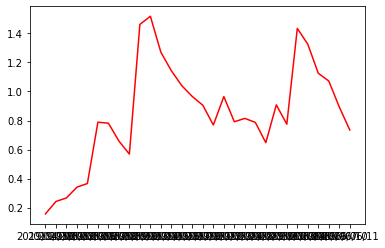

In [130]:
basic_gm = arch_model(sp_data['Return'].dropna(), p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')

start_loc=2081
end_loc=2220
forecasts = {}
for i in range(30):
    # Specify fixed rolling window size for model fitting
    gm_result = basic_gm.fit(first_obs = i + start_loc, 
                             last_obs = i + end_loc, update_freq = 5)
    
    # Conduct 1-period variance forecast and save the result
    temp_result = gm_result.forecast(horizon = 1).variance
    fcast = temp_result.iloc[i + end_loc]
    forecasts[fcast.name] = fcast
    
# Save all forecast to a dataframe    
forecast_var = pd.DataFrame(forecasts).T

# Plot the forecast variance
plt.plot(forecast_var, color = 'red')
plt.plot(sp_data.Return['2019-4-1':'2019-5-10'], color = 'green')
plt.show()

In [131]:
forecast_var

,h.1
2019/04/30,0.156509
2019/05/01,0.242055
2019/05/02,0.266608
2019/05/03,0.340691
2019/05/06,0.365964
2019/05/07,0.788369
2019/05/08,0.781657
2019/05/09,0.658912
2019/05/10,0.568697
2019/05/13,1.461814


 -----------------------------------------------------------------------------------------------------------------------------------------------------------------<br>
### Model performance evaluation

-"Goodness of fit" describes how well the model fits a set of observations. Measures of "goodness of fit" typically summarize the discrepancy between observed values and the values estimated by the model. Common measures include the maximum likelihood and information criteria.

-GARCH models use the maximum likelihood method to estimate parameters. In general, the bigger the log-likelihood, the better the model since it implies a bigger probability of having observed the data you got.

-Keep it simple stupid (KISS): Always keep the most parsimonious model with parameters that are relevant. Simplicity is the ultimate sophistication.

-GARCH models make strict assumptions about the distribution characteristics of the standardized residuals. If the model is doing a good job at explaining the data, the standardized residuals should not exhibit data clustering or autocorrelations.

-The coefficient of correlation between two values in a time series is called the autocorrelation function (ACF), and an ACF plot is a visual representation of correlations between different lags.

-Information criteria: measure the trade-off between goodness of fit and model complexity. They consider the model likelihood but add penalties for model complexity.

-Akaike's and Bayesian Information Criterion (AIC, BIC). Models with lower scores are preferred. BIC imposes bigger penalties on models with more parameters so as to lead to selecting more parsimonious models than AIC.

-Information criteria intend to measure the trade-off between goodness of fit and model complexity. AIC and BIC are two commonly used information criteria for model selection. They both impose penalties on model with more parameters, or more complex models. The lower the AIC or BIC, the better the model.

-Backtesting: a method to evaluate model forecasting capability by comparing model predictions with actual historical data. In-sample data is used for model fitting, Out-of-sample data is used for backtesting. Use Mean Absolute Error (MAE) or Mean Squared Error (MSE) for evaluation. Backtesting is a common approach to assess model performance ex-post. "Ex-post" means "after the fact". During a backtesting, model forecasts are compared with the actual historical data to see how well the model would have performed.

In [ ]:
# Print model fitting summary
print(gm_result.summary())

# Get parameter stats from model summary
para_summary = pd.DataFrame({'parameter':gm_result.params,
                             'p-value': gm_result.pvalues})

# Print out parameter stats
print(para_summary)

In [ ]:
# Get parameter stats from model summary
para_summary = pd.DataFrame({'parameter':gm_result.params,
                             'std-err': gm_result.std_err, 
                             't-value': gm_result.tvalues})

# Verify t-statistic by manual calculation
calculated_t = para_summary['parameter']/para_summary['std-err']

# Print calculated t-value
print(calculated_t)

# Print parameter stats
print(para_summary)

In [ ]:
# Import the Python module
from statsmodels.graphics.tsaplots import plot_acf

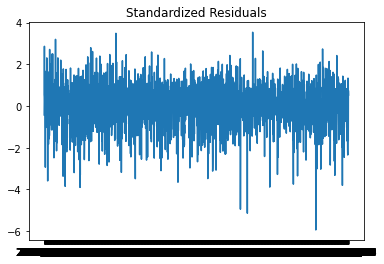

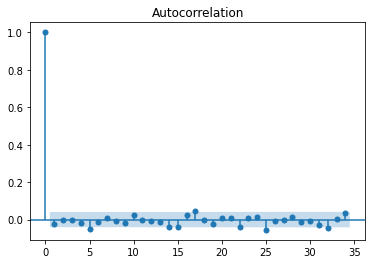

In [20]:
# Plot the standardized residuals
plt.plot(gm_result.std_resid)
plt.title('Standardized Residuals')
plt.show()

# Generate ACF plot of the standardized residuals
plot_acf(gm_result.std_resid, alpha = 0.05)
plt.show()

In [21]:
# Import the Python module
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform the Ljung-Box test
lb_test = acorr_ljungbox(gm_result.std_resid, lags = 10)

# Print the p-values
print('P-values are: ', lb_test[1])

P-values are:  [0.22953206 0.48521636 0.6851136  0.71598142 0.16630508 0.2258332
 0.30264537 0.39337674 0.39983992 0.38763133]


/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [28]:
skewt_result = arch_model(sp_data['Return'].dropna(), p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'skewt').fit()


# Print the log-likelihodd of normal GARCH
print('Log-likelihood of normal GARCH :', gm_result.loglikelihood)

# Print the log-likelihodd of skewt GARCH
print('Log-likelihood of skewt GARCH :', skewt_result.loglikelihood)

Iteration:      1,   Func. Count:      8,   Neg. LLF: 109840.37880541019
Iteration:      2,   Func. Count:     19,   Neg. LLF: 134482.95887494896
Iteration:      3,   Func. Count:     28,   Neg. LLF: 18474.707357875606
Iteration:      4,   Func. Count:     36,   Neg. LLF: 5471.602579325621
Iteration:      5,   Func. Count:     44,   Neg. LLF: 4963.102957824691
Iteration:      6,   Func. Count:     52,   Neg. LLF: 2734.2288269058663
Iteration:      7,   Func. Count:     60,   Neg. LLF: 2727.7741406594555
Iteration:      8,   Func. Count:     68,   Neg. LLF: 5015.2291784435065
Iteration:      9,   Func. Count:     76,   Neg. LLF: 2742.0455830623046
Iteration:     10,   Func. Count:     84,   Neg. LLF: 2697.5698952216053
Iteration:     11,   Func. Count:     92,   Neg. LLF: 2690.1090740137242
Iteration:     12,   Func. Count:    100,   Neg. LLF: 2688.684634827148
Iteration:     13,   Func. Count:    107,   Neg. LLF: 2688.6644250985983
Iteration:     14,   Func. Count:    114,   Neg. LLF: 

In [35]:
# AIC
print('AIC:')
print(gm_result.aic)
print(skewt_result.aic)

# BIC
print('\n'+'BIC:')
print(gm_result.bic)
print(skewt_result.bic)

AIC:
5548.16433008987
5389.324185541058

BIC:
5571.187398770282
5423.858788561676


In [66]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

actual_var = sp_data['Return'].dropna()
forecast_var = [np.random.normal(size = 1)[0] for i in actual_var.iteritems()]

def evaluate(observation, forecast): 
    # Call sklearn function to calculate MAE
    mae = mean_absolute_error(observation, forecast)
    print('Mean Absolute Error (MAE): {:.3g}'.format(mae))
    # Call sklearn function to calculate MSE
    mse = mean_squared_error(observation, forecast)
    print('Mean Squared Error (MSE): {:.3g}'.format(mse))
    return mae, mse

# Backtest model with MAE, MSE
evaluate(actual_var, forecast_var)

Mean Absolute Error (MAE): 1.07
Mean Squared Error (MSE): 1.89


(1.06734021777887, 1.8947689264018956)

 -----------------------------------------------------------------------------------------------------------------------------------------------------------------<br>
### VaR with GARCH

-With GARCH models, VaR can incorporate the time-varying characteristics of volatility and give more realistic estimations of potential losses.

-There are three steps to perform a forward VaR estimation. Step 1 is to use a GARCH model to make variance forecasts. Step 2 is to obtain the GARCH forward-looking mean and volatility. And Step 3 is to compute the quantile according to a given confidence level. The parametric approach estimates quantiles from an assumed distribution assumption.

-The difference between parametric VaR and empirical VaR is how the quantiles are estimated. The parametric approach estimates quantiles from an assumed distribution assumption, while the empirical approach estimates quantiles from an observed distribution of the standardized residuals.

-Covariance is used in various areas in portfolio management. With GARCH models, one can compute the dynamic covariance to incorporate the time-varying characteristic of volatility. And in Modern Portfolio Theory, covariance demonstrates the diversification benefit of combining different types of assets.

-Beta is a popular tool used in portfolio management to gauge investment risks. A stock Beta measures the volatility of an individual stock in relation to the general market. Dynamic Beta can be computed with GARCH models to account for the time-varying quality of volatility.

In [164]:
# Specify GARCH model assumptions -> GARCH(1,1)
btc['Return'].index = pd.to_datetime(btc['Return'].index)
basic_gm = arch_model(btc['Return'], p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 't')

# Fit the model
gm_result = basic_gm.fit(update_freq = 4)

gm_forecast = gm_result.forecast(start = '2019-01-01')

Iteration:      4,   Func. Count:     31,   Neg. LLF: 5042.489163222513
Iteration:      8,   Func. Count:     59,   Neg. LLF: 4951.861610456446
Iteration:     12,   Func. Count:     86,   Neg. LLF: 3966.9909776951986
Iteration:     16,   Func. Count:    110,   Neg. LLF: 3966.2671136498507
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3966.2668121063334
            Iterations: 19
            Function evaluations: 127
            Gradient evaluations: 19


/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [165]:
# Obtain the parametric quantile
degrees_of_freedom=3.0099
q_parametric = basic_gm.distribution.ppf(0.05, degrees_of_freedom)
print('5% parametric quantile: ', q_parametric)

mean_forecast = gm_forecast.mean['2019-01-01':]
variance_forecast = gm_forecast.variance['2019-01-01':]

5% parametric quantile:  -1.3613507371501754


,5%
Date,
2019-11-27,-5.130989
2019-11-28,-4.836781
2019-11-29,-4.641262
2019-12-02,-5.046098
2019-12-03,-4.758319


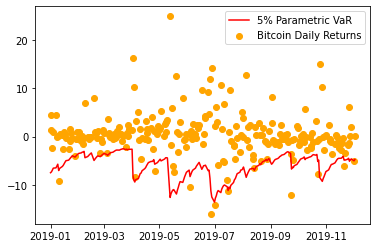

In [172]:
# Calculate the VaR
VaR_parametric = mean_forecast.values + np.sqrt(variance_forecast).values * q_parametric
# Save VaR in a DataFrame
VaR_parametric = pd.DataFrame(VaR_parametric, columns = ['5%'], index = variance_forecast.index)
display(VaR_parametric.tail())

# Plot the VaR
plt.plot(VaR_parametric, color = 'red', label = '5% Parametric VaR')
plt.scatter(variance_forecast.index,btc.Return['2019-1-1':], color = 'orange',
            label = 'Bitcoin Daily Returns' )
plt.legend(loc = 'upper right')
plt.show()

5% empirical quantile:  -1.4979537346597922


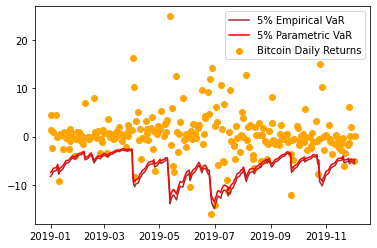

In [174]:
# Obtain the empirical quantile
std_resid = gm_result.std_resid
q_empirical = std_resid.quantile(0.05)
print('5% empirical quantile: ', q_empirical)

# Calculate the VaR
VaR_empirical = mean_forecast.values + np.sqrt(variance_forecast).values * q_empirical
# Save VaR in a DataFrame
VaR_empirical = pd.DataFrame(VaR_empirical, columns = ['5%'], index = variance_forecast.index)

# Plot the VaRs
plt.plot(VaR_empirical, color = 'brown', label = '5% Empirical VaR')
plt.plot(VaR_parametric, color = 'red', label = '5% Parametric VaR')
plt.scatter(variance_forecast.index,btc.Return['2019-1-1':], color = 'orange', label = 'Bitcoin Daily Returns' )
plt.legend(loc = 'upper right')
plt.show()